In [1]:
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
import casadi as ca
import pandas as pd

# General Pipline

![](./safety_pipline.png)


# Load track data

In [2]:
# 1. set file path
file_path = "Monza.csv"

# 2. read csv file
df = pd.read_csv(file_path)

# 3. look head
print(df.head())

# 4. rename the first row
##df.rename(columns={'# x_m': 'x_m'}, inplace=True)

# 5. read the columns
x = df['# x_m'].values
y = df['y_m'].values
w_left = df['w_tr_left_m'].values
w_right = df['w_tr_right_m'].values

      # x_m        y_m  w_tr_right_m  w_tr_left_m
0 -0.320123   1.087714         5.739        5.932
1  0.168262   6.062191         5.735        5.929
2  0.656139  11.036647         5.731        5.926
3  1.143549  16.011082         5.727        5.923
4  1.630535  20.985493         5.723        5.920


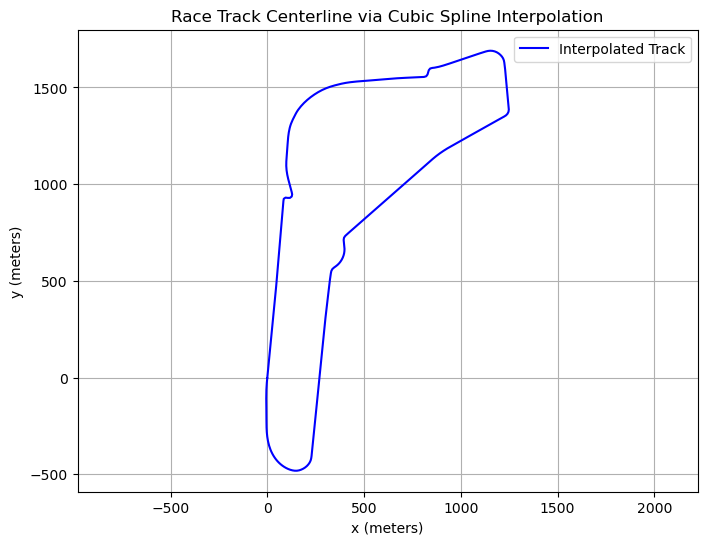

In [3]:
# Step 1: Compute arclengths
s = np.zeros(len(x))
s[1:] = np.cumsum(np.sqrt(np.diff(x)**2 + np.diff(y)**2))
s_max=s[-1] #the length of the track

# Step 2: Create cubic spline interpolators
x_spline = CubicSpline(s, x)
y_spline = CubicSpline(s, y)

# Step 3: Get the first and second derivative of the parameteriation
dx_ds = x_spline.derivative(1)
d2x_ds2 = x_spline.derivative(2)
dy_ds = y_spline.derivative(1)
d2y_ds2 = y_spline.derivative(2)

## Generate interpolated values for plotting
s_query = np.linspace(0, s_max, 500)
x_interp = x_spline(s_query)
y_interp = y_spline(s_query)

## Plot the spline
plt.figure(figsize=(8, 6))
plt.plot(x_interp, y_interp, label='Interpolated Track', color='blue')
##plt.plot(x, y, 'ro', label='Original Points')
plt.axis('equal')
plt.title('Race Track Centerline via Cubic Spline Interpolation')
plt.xlabel('x (meters)')
plt.ylabel('y (meters)')
plt.legend()
plt.grid(True)
plt.show()

# output parameterisation and curvature as a casadi instance
x_ref = ca.interpolant('x_ref', 'linear', [s_query], x_interp)
y_ref = ca.interpolant('y_ref', 'linear', [s_query], y_interp)
kappa_ref_ = dx_ds(s_query)*d2y_ds2(s_query)-dy_ds(s_query)*d2x_ds2(s_query)
kappa_ref = ca.interpolant('kappa', 'linear', [s_query], kappa_ref_)

# Load global trajectory

In [831]:
# file path
file_path = './optimal_trajectory_1.csv'

# read CSV
df = pd.read_csv(file_path)

# look first 5 entry
print(df.head())


      s          v      beta     omega             n        xi     delta  \
0   0.0  10.000000  0.000000  0.000000  0.000000e+00  0.000000  0.019703   
1   3.0  10.060300  0.000042  0.000387  9.326291e-08 -0.000015  0.016407   
2   6.0  10.120099 -0.000037  0.000706  8.033378e-05  0.000070  0.013634   
3   9.0  10.179402 -0.000213  0.000969  1.794186e-04  0.000236 -0.013564   
4  12.0  10.238221 -0.000501  0.000688  2.474330e-04  0.000480 -0.015080   

         F_dr  
0  435.857199  
1  435.508531  
2  435.143993  
3  434.794007  
4  434.417913  


In [832]:
s     = df['s'].to_numpy()
v     = df['v'].to_numpy()
beta  = df['beta'].to_numpy()
omega = df['omega'].to_numpy()
n     = df['n'].to_numpy()
xi    = df['xi'].to_numpy()
delta = df['delta'].to_numpy()
F_dr  = df['F_dr'].to_numpy()

In [1207]:
s0=300
S_fov=330

In [1208]:
#  Use boolean indexing to filter rows where s is between 3690 and 3972.
mask = (df['s'] >= s0) & (df['s'] <= S_fov)
df_sub = df.loc[mask]

#  Get corresponding values 
s_sub     = df_sub['s'].to_numpy()
v_sub     = df_sub['v'].to_numpy()
beta_sub  = df_sub['beta'].to_numpy()
omega_sub = df_sub['omega'].to_numpy()
n_sub     = df_sub['n'].to_numpy()
xi_sub    = df_sub['xi'].to_numpy()
delta_sub = df_sub['delta'].to_numpy()[:-1]
Fdr_sub   = df_sub['F_dr'].to_numpy()[:-1]

In [1209]:
n_sub.shape

(11,)

# Safety check problem formulation (A)

$$
\begin{aligned}
&\min\; v^2(s_{fov})\\
\text{s.t.}\quad
&\frac{dx}{ds} = f\bigl(x(s),u(s)\bigr) &&(\text{Car Dynamics Constraints})\\
&h\bigl(x(s),u(s)\bigr) \le 0        &&(\text{Environment Constraints})\\
&x(s_0) = x_0                       &&(\text{Initial State Constraints})\\
&v(s)>0,\quad s\in[s_0,s_{fov}]     &&(\text{Feasibility Constraint})
\end{aligned}
$$

If the optimized result $v(s_{fov})$ is smaller than $v_0$, then safety is assured.

In [1168]:
##==car parameter==##
m = 1500
g = 9.81
mu_roll = 0.008
mu = 1
F_MAX = 2000
F_MIN = -13200 ##breaking force
delta_MAX = np.pi / 6
J_zz = 3000
l_f = 1.5
l_r = 1.5
w_f = 1.2
w_r = 1.2
##================##

##==Initialize the independent variable (i.e. s)==#
ds = 3 ## step size for the arclength
N = int((S_fov-s0)/ds+1) ## number of discretization
s = np.linspace(s0,S_fov,N)
# or can take the s from data

opti = ca.Opti()

# Variables
n = opti.variable(N)
xi = opti.variable(N)
beta = opti.variable(N)
psi_dot = opti.variable(N)
v = opti.variable(N)
delta_f = opti.variable(N-1)
F_dr = opti.variable(N-1)
dtds = opti.variable(N)

##==Get the global solution for states and corresponding control from s0 to S_fov==##
#They are used as initial guess for opti
n_guess = n_sub
xi_guess = xi_sub
beta_guess = beta_sub
psi_dot_guess = omega_sub
v_guess = v_sub
delta_f_guess = delta_sub
F_dr_guess = Fdr_sub

##==Define some constants==##
F_roll = mu_roll * m * g
F_Z = m * g / 4
v0=0.5

for k in range(N-1):
    kappa = kappa_ref(s[k])
    # slip angle for 4 tyres
    alpha_fl = delta_f[k] - ca.atan2(v[k]*ca.sin(beta[k]) + l_f*psi_dot[k], v[k]*ca.cos(beta[k]) - w_f/2*psi_dot[k])
    alpha_fr = delta_f[k] - ca.atan2(v[k]*ca.sin(beta[k]) + l_f*psi_dot[k], v[k]*ca.cos(beta[k]) + w_f/2*psi_dot[k])
    alpha_rl = 0 - ca.atan2(v[k]*ca.sin(beta[k]) - l_r*psi_dot[k], v[k]*ca.cos(beta[k]) - w_r/2*psi_dot[k])
    alpha_rr = 0 - ca.atan2(v[k]*ca.sin(beta[k]) - l_r*psi_dot[k], v[k]*ca.cos(beta[k]) + w_r/2*psi_dot[k])
    # magical formula for tyre lateral force
    F_y = lambda alpha: ca.sin(1.9 * ca.atan(10 * ca.sin(alpha))) + 0.97 * ca.sin(ca.atan(10 * ca.sin(alpha)))
    FYfl = F_y(alpha_fl)
    FYfr = F_y(alpha_fr)
    FYrl = F_y(alpha_rl)
    FYrr = F_y(alpha_rr)
    # system dynamics

    dn = dtds[k] * (v[k]*ca.sin(xi[k] + beta[k]))
    dxi = dtds[k] * psi_dot[k] - kappa
    dbeta = dtds[k] * (-psi_dot[k] + 1/(m*v[k]) * (
        (FYfl + FYfr)*ca.cos(delta_f[k] - beta[k]) +
        (FYrl + FYrr)*ca.cos(- beta[k]) - F_dr[k]*ca.sin(beta[k])
    ))
    dpsi_dot = dtds[k]/J_zz * (
        FYfl*(l_f*ca.cos(delta_f[k]) - w_f/2*ca.sin(delta_f[k])) +
        FYfr*(l_f*ca.cos(delta_f[k]) + w_f/2*ca.sin(delta_f[k])) +
        FYrl*(-l_r) +
        FYrr*(-l_r)
    )
    dv = dtds[k]/m * (
        (FYfl + FYfr)*ca.sin(beta[k] - delta_f[k]) +
        (FYrl + FYrr)*ca.sin(beta[k]) +
        F_dr[k]*ca.cos(beta[k]) - F_roll
    )
    # equality constraint
    opti.subject_to(dtds[k] == (1 - n[k]*kappa) / v[k]*ca.cos(xi[k] + beta[k]))

    # Integrate
    opti.subject_to(n[k+1] == n[k] + ds*dn)
    opti.subject_to(xi[k+1] == xi[k] + ds*dxi)
    opti.subject_to(beta[k+1] == beta[k] + ds*dbeta)
    opti.subject_to(psi_dot[k+1] == psi_dot[k] + ds*dpsi_dot)
    opti.subject_to(v[k+1] == v[k] + ds*dv)

    # Control and friction constraints
    opti.subject_to(F_dr[k] <= F_MAX)
    opti.subject_to(F_dr[k] >= F_MIN)
    opti.subject_to(ca.fabs(delta_f[k]) <= delta_MAX)

    opti.subject_to((FYfl/(mu*F_Z))**2 + (0.25*F_roll/(mu*F_Z))**2 <= 1)
    opti.subject_to((FYfr/(mu*F_Z))**2 + (0.25*F_roll/(mu*F_Z))**2 <= 1)
    opti.subject_to((FYrl/(mu*F_Z))**2 + (0.25*(F_dr[k]+F_roll)/(mu*F_Z))**2 <= 1)
    opti.subject_to((FYrr/(mu*F_Z))**2 + (0.25*(F_dr[k]+F_roll)/(mu*F_Z))**2 <= 1)

# Initial state constraint
opti.subject_to(n[0] == n_guess[0])
opti.subject_to(xi[0] == xi_guess[0])
opti.subject_to(beta[0] == beta_guess[0])
opti.subject_to(psi_dot[0] == psi_dot_guess[0])
opti.subject_to(v[0] == v_guess[0])  ##刹车时的速度

# Final state constraint
# first consider no finial state constraint
#opti.subject_to(n[N-1] == 0)
#opti.subject_to(xi[N-1] == 0)
#opti.subject_to(beta[N-1] == 0)
#opti.subject_to(psi_dot[N-1] == 0)
#opti.subject_to(v[N-1] == 0.02)

# State constraint
for k in range(N):
    opti.subject_to(v[k] >= 0.1)
    nmin, nmax = -10, 10
    opti.subject_to(n[k] >= nmin)
    opti.subject_to(n[k] <= nmax)
# Avoid accelerating when braking
for k in range(N-1):
    opti.subject_to(F_dr[k] <= 1) # less than 1 rather than 0 to avoid 0 speed 

# Objective
opti.minimize((100*v[N-1])**2)

opti.set_initial(n, n_guess)
opti.set_initial(xi, xi_guess)
opti.set_initial(beta, beta_guess)
opti.set_initial(psi_dot, psi_dot_guess)
opti.set_initial(v, v_guess)
opti.set_initial(delta_f, delta_f_guess)
opti.set_initial(F_dr, -np.abs(F_dr_guess)) # Set the initial guess for the braking force to the negative of the absolute value of the global solution

In [1169]:
opti.solver('ipopt', {"expand": True}, {
        "print_level": 0, "tol": 1e-4,
        "acceptable_tol": 1e-2, "acceptable_iter": 10,
        "max_iter": 5000,
        "constr_viol_tol": 1e-3,
        "compl_inf_tol": 1e-3,
        "acceptable_constr_viol_tol": 1e-3,
    })

In [1170]:
print(F_dr_guess)

[375.51406763 375.61920975 375.70424864 375.76666002 375.80440754
 375.81492867 375.79597615 375.74454785 375.65779782 375.53285502
 375.36626619 375.154483   374.89353713 374.57856488 374.22835571
 373.83637093 373.37728683 372.83380261 372.18840407 371.44346194
 370.58937044 369.62038816 368.53407557 367.33185899 366.01739415
 364.59887704 363.07896468 361.46032951 359.74589395 357.93848691]


In [1171]:
sol = opti.solve()

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  54.00us (593.41ns)  51.42us (565.00ns)        91
       nlp_g  |   1.81ms ( 19.85us)   1.78ms ( 19.58us)        91
  nlp_grad_f  |  63.00us (  1.21us)  51.12us (983.12ns)        52
  nlp_hess_l  |   6.28ms (125.54us)   6.29ms (125.82us)        50
   nlp_jac_g  |   2.66ms ( 51.19us)   2.68ms ( 51.50us)        52
       total  |  73.99ms ( 73.99ms)  73.99ms ( 73.99ms)         1


In [1172]:
opti.debug.value(F_dr)

array([-2145.28692207, -2145.17557564, -2145.13784105, -2145.18500341,
       -2145.33102522, -2145.5919615 , -2145.98725196, -2146.53931257,
       -2147.2751753 , -2148.22724559, -2149.43394107, -2150.94165907,
       -2152.80636516, -2155.09563445, -2157.91612604, -2161.36962557,
       -2165.56574283, -2170.65633453, -2176.83931406, -2184.39570666,
       -2193.6847767 , -2205.20140384, -2219.6457848 , -2238.05002074,
       -2262.0227746 , -2294.28876559, -2340.02827062, -2410.97718068,
       -2541.77835304, -2899.25041198])

In [1173]:
opti.debug.value(v)

array([16.14771527, 15.86943228, 15.58630506, 15.29806626, 15.0044218 ,
       14.70504821, 14.39958755, 14.08764231, 13.76876986, 13.44247439,
       13.10819648, 12.76530609, 12.41308085, 12.05069269, 11.67718602,
       11.29144321, 10.89214533, 10.47772773, 10.04630595,  9.59557842,
        9.12268298,  8.62399403,  8.09481084,  7.52886476,  6.91749824,
        6.24820726,  5.50181924,  4.64649388,  3.62157222,  2.28425512,
        0.10000004])

In [1174]:
opti.debug.value(n)

array([-0.96705028, -0.9048622 , -0.84900752, -0.79974151, -0.75734256,
       -0.72211515, -0.69439345, -0.67454556, -0.66297845, -0.66014392,
       -0.6665459 , -0.68274928, -0.70939086, -0.74719293, -0.7969803 ,
       -0.85970206, -0.93646   , -1.02854572, -1.13749003, -1.26513026,
       -1.4137039 , -1.585983  , -1.78547244, -2.01671339, -2.28576842,
       -2.60104008, -2.97474731, -3.42582829, -3.98687914, -4.7193067 ,
       -5.76366673])

In [1175]:
opti.debug.value(delta_f)

array([ 1.61019474e-02,  1.73069419e-02,  1.62778758e-02,  1.48297475e-02,
        1.24051002e-02,  1.00796028e-02,  8.39325789e-03,  6.58174806e-03,
        4.76499596e-03,  4.96853094e-03,  8.58548289e-04, -8.61913974e-06,
        8.26065569e-04,  5.67404583e-05, -4.02956442e-03, -6.63374125e-03,
       -1.06474016e-02, -1.52361304e-02, -2.05363066e-02, -2.67371279e-02,
       -3.41086330e-02, -4.30284564e-02, -5.39381171e-02, -6.71655615e-02,
       -8.41836532e-02, -1.08651223e-01, -2.53068499e-01, -2.65188099e-01,
       -3.74897149e-01, -4.37000457e-01])

In [1176]:
opti.debug.value(s)

array([510., 513., 516., 519., 522., 525., 528., 531., 534., 537., 540.,
       543., 546., 549., 552., 555., 558., 561., 564., 567., 570., 573.,
       576., 579., 582., 585., 588., 591., 594., 597., 600.])

In [1177]:
opti.debug.value(xi)

array([0.1456718 , 0.14456755, 0.14344924, 0.14231594, 0.14116659,
       0.14000006, 0.13881502, 0.13761006, 0.13638363, 0.13513401,
       0.13385927, 0.13255728, 0.13122553, 0.12986132, 0.12846153,
       0.12702251, 0.12553996, 0.12400882, 0.12242304, 0.1207754 ,
       0.11905708, 0.11725702, 0.1153612 , 0.11335125, 0.11120227,
       0.10887912, 0.10632893, 0.10346476, 0.09960698, 0.09432963,
       0.08435389])

In [1178]:
opti.debug.value(psi_dot)

array([-0.00532099, -0.00531831, -0.00531573, -0.00531337, -0.00531126,
       -0.00530944, -0.00530793, -0.00530669, -0.00530572, -0.00530502,
       -0.00530441, -0.0053042 , -0.0053041 , -0.00530399, -0.00530395,
       -0.00530401, -0.00530402, -0.00530389, -0.00530345, -0.00530249,
       -0.00530069, -0.00529762, -0.00529273, -0.00528522, -0.0052739 ,
       -0.00525726, -0.00523448, -0.00602276, -0.00653679, -0.00816698,
       -0.00870287])

In [1179]:
opti.debug.value(beta)

array([-0.12493727, -0.12594565, -0.1270248 , -0.12818148, -0.12942336,
       -0.13075919, -0.13219901, -0.1337544 , -0.13543881, -0.13726797,
       -0.1392604 , -0.1414381 , -0.14382731, -0.14645983, -0.14937446,
       -0.15261913, -0.15625383, -0.16035474, -0.16502024, -0.17037997,
       -0.17660882, -0.18394908, -0.19274762, -0.20352112, -0.21707839,
       -0.23476913, -0.2590463 , -0.29513292, -0.35465484, -0.47937626,
       -0.9427308 ])

# Decelerate for safety (C)

$$
\begin{aligned}
&\min\; v^2(s_{fov})\\
\text{s.t.}\quad
&\frac{dx}{ds} = f\bigl(x(s),u(s)\bigr) &&(\text{Car Dynamics Constraints})\\
&h\bigl(x(s),u(s)\bigr) \le 0        &&(\text{Environment Constraints})\\
&n(s) = n_{global}(s) \text{ for all }s \in (s_0,s_{fov}]                      &&(\text{Following the geometric path from global solution, 1})\\
&x(s_0) = x_0                       &&(\text{Initial state constraint})\\
&v(s)>0,\quad s\in[s_0,s_{fov}]     &&(\text{Feasibility Constraint})\\
&F_{dr}(s_0)<0 &&(\text{The first control must be braking})
\end{aligned}
$$
(1) is implenmented with torelance. Then take the first control step

In [1210]:
##==car parameter==##
m = 1500
g = 9.81
mu_roll = 0.008
mu = 1
F_MAX = 2000
F_MIN = -13200 ##breaking force
delta_MAX = np.pi / 6
J_zz = 3000
l_f = 1.5
l_r = 1.5
w_f = 1.2
w_r = 1.2
##================##

##==Initialize the independent variable (i.e. s)==#
ds = 3 ## step size for the arclength
N = int((S_fov-s0)/ds+1) ## number of discretization
s = np.linspace(s0,S_fov,N)
# or can take the s from data

opti = ca.Opti()

# Variables
n = opti.variable(N)
xi = opti.variable(N)
beta = opti.variable(N)
psi_dot = opti.variable(N)
v = opti.variable(N)
delta_f = opti.variable(N-1)
F_dr = opti.variable(N-1)
dtds = opti.variable(N)

##==Get the global solution for states and corresponding control from s0 to S_fov==##
# The following guess is to be followed by the car as a euqlity constraint during opt
n_guess = n_sub
xi_guess = xi_sub
beta_guess = beta_sub
psi_dot_guess = omega_sub
delta_f_guess = delta_sub

# They are used as initial guess for opti
v_guess = v_sub
F_dr_guess = Fdr_sub

##==Define some constants==##
F_roll = mu_roll * m * g
F_Z = m * g / 4

for k in range(N-1):
    kappa = kappa_ref(s[k])
    # slip angle for 4 tyres
    alpha_fl = delta_f[k] - ca.atan2(v[k]*ca.sin(beta[k]) + l_f*psi_dot[k], v[k]*ca.cos(beta[k]) - w_f/2*psi_dot[k])
    alpha_fr = delta_f[k] - ca.atan2(v[k]*ca.sin(beta[k]) + l_f*psi_dot[k], v[k]*ca.cos(beta[k]) + w_f/2*psi_dot[k])
    alpha_rl = 0 - ca.atan2(v[k]*ca.sin(beta[k]) - l_r*psi_dot[k], v[k]*ca.cos(beta[k]) - w_r/2*psi_dot[k])
    alpha_rr = 0 - ca.atan2(v[k]*ca.sin(beta[k]) - l_r*psi_dot[k], v[k]*ca.cos(beta[k]) + w_r/2*psi_dot[k])
    # magical formula for tyre lateral force
    F_y = lambda alpha: ca.sin(1.9 * ca.atan(10 * ca.sin(alpha))) + 0.97 * ca.sin(ca.atan(10 * ca.sin(alpha)))
    FYfl = F_y(alpha_fl)
    FYfr = F_y(alpha_fr)
    FYrl = F_y(alpha_rl)
    FYrr = F_y(alpha_rr)
    # system dynamics
    dn = dtds[k] * (v[k]*ca.sin(xi[k] + beta[k]))
    dxi = dtds[k] * psi_dot[k] - kappa
    dbeta = dtds[k] * (-psi_dot[k] + 1/(m*v[k]) * (
        (FYfl + FYfr)*ca.cos(delta_f[k] - beta[k]) +
        (FYrl + FYrr)*ca.cos(- beta[k]) - F_dr[k]*ca.sin(beta[k])
    ))
    dpsi_dot = dtds[k]/J_zz * (
        FYfl*(l_f*ca.cos(delta_f[k]) - w_f/2*ca.sin(delta_f[k])) +
        FYfr*(l_f*ca.cos(delta_f[k]) + w_f/2*ca.sin(delta_f[k])) +
        FYrl*(-l_r) +
        FYrr*(-l_r)
    )
    dv = dtds[k]/m * (
        (FYfl + FYfr)*ca.sin(beta[k] - delta_f[k]) +
        (FYrl + FYrr)*ca.sin(beta[k]) +
        F_dr[k]*ca.cos(beta[k]) - F_roll
    )

    # Integrate
    opti.subject_to(n[k+1] == n[k] + ds*dn)
    opti.subject_to(xi[k+1] == xi[k] + ds*dxi)
    opti.subject_to(beta[k+1] == beta[k] + ds*dbeta)
    opti.subject_to(psi_dot[k+1] == psi_dot[k] + ds*dpsi_dot)
    opti.subject_to(v[k+1] == v[k] + ds*dv)

    # Control and friction constraints
    opti.subject_to(F_dr[k] <= F_MAX)
    opti.subject_to(F_dr[k] >= F_MIN)
    opti.subject_to(ca.fabs(delta_f[k]) <= delta_MAX)

    opti.subject_to((FYfl/(mu*F_Z))**2 + (0.25*F_roll/(mu*F_Z))**2 <= 1)
    opti.subject_to((FYfr/(mu*F_Z))**2 + (0.25*F_roll/(mu*F_Z))**2 <= 1)
    opti.subject_to((FYrl/(mu*F_Z))**2 + (0.25*(F_dr[k]+F_roll)/(mu*F_Z))**2 <= 1)
    opti.subject_to((FYrr/(mu*F_Z))**2 + (0.25*(F_dr[k]+F_roll)/(mu*F_Z))**2 <= 1)

for k in range(N):
    # equality constraint
    opti.subject_to(dtds[k] == (1 - n[k]*kappa_ref(s[k])) / v[k]*ca.cos(xi[k] + beta[k]))

# Initial state constraint
# the first 1 is redundant 
#opti.subject_to(n[0] == n_guess[0])
opti.subject_to(xi[0] == xi_guess[0])
opti.subject_to(beta[0] == beta_guess[0])
opti.subject_to(psi_dot[0] == psi_dot_guess[0])
opti.subject_to(v[0] == v_guess[0])  ##initial speed


# State constraint

n_tolerance = 0.1 # meters
for k in range(N):
    opti.subject_to(v[k] >= 0.1)
    # geometric path following
    # Allow for some small deviation
    opti.subject_to(ca.fabs(n[k] - n_guess[k]) <= n_tolerance)
    #opti.subject_to(xi[k] == xi_guess[k])
    #opti.subject_to(beta[k] == beta_guess[k])
    #opti.subject_to(psi_dot[k] == psi_dot_guess[k])
    
# F_dr can not be greater than F_dr_guess
#for k in range(N-1):
#    opti.subject_to(F_dr[k] <= F_guess[k])

# The first control step is braking
opti.subject_to(F_dr[0] <= 0)#F_dr_guess[0])

# The final speed must be smaller than original
#opti.subject_to(v[N-1] <= v_guess[N-1])

# =========================================================
# == 新增：添加速度单调递减的约束 ==
# =========================================================
#for k in range(N-1):
#    opti.subject_to(v[k+1] < v[k])
# =========================================================


# Objective
opti.minimize(v[N-1]**2)

opti.set_initial(n, n_guess)
opti.set_initial(xi, xi_guess)
opti.set_initial(beta, beta_guess)
opti.set_initial(psi_dot, psi_dot_guess)
opti.set_initial(v, v_guess)
opti.set_initial(delta_f, delta_f_guess)
opti.set_initial(F_dr, F_dr_guess) # Set the initial guess for the braking force to the negative of the absolute value of the global solution




In [1211]:
opti.solver('ipopt', {"expand": True}, {
        "print_level": 0, "tol": 1e-4,
        "acceptable_tol": 1e-2, "acceptable_iter": 10,
        "max_iter": 5000,
        "constr_viol_tol": 1e-3,
        "compl_inf_tol": 1e-3,
        "acceptable_constr_viol_tol": 1e-3,
    })

In [1212]:
sol = opti.solve()

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 716.00us (575.56ns) 662.71us (532.73ns)      1244
       nlp_g  |   8.45ms (  6.79us)   8.28ms (  6.66us)      1244
  nlp_grad_f  | 214.00us (761.57ns) 202.18us (719.48ns)       281
  nlp_hess_l  |  16.30ms ( 41.38us)  16.35ms ( 41.48us)       394
   nlp_jac_g  |   7.32ms ( 17.17us)   7.35ms ( 17.24us)       426
       total  | 252.32ms (252.32ms) 252.33ms (252.33ms)         1


In [1213]:
opti.debug.value(v)

array([14.41570226, 13.8512891 , 14.12077532, 14.38511816, 14.64477041,
       14.89971255, 15.15038066, 14.31796526, 12.47223482, 10.35924662,
        7.82848456])

In [1214]:
v_guess

array([14.41570226, 14.44494793, 14.47394637, 14.50280976, 14.53145781,
       14.55989903, 14.58814183, 14.61608692, 14.64383664, 14.6713945 ,
       14.69876402])

In [1215]:
opti.debug.value(F_dr)

array([ -3972.57061369,   1999.97626961,   1999.97655243,   1999.97656055,
         1999.97648904,   1999.97618595,  -6229.53970704, -13199.98984361,
       -13199.99501852, -13199.99707774])

In [1216]:
F_dr_guess

array([385.98001745, 385.18251916, 384.50769131, 383.84528711,
       383.21193709, 382.60708994, 381.93265745, 381.29069026,
       380.66549214, 380.05732951])

# Maximize speed when safety assured (B)

$$
\begin{aligned}
&\min\; \int_{s_0}^{s_0+H} \frac{dt}{ds} \, ds\\
\text{s.t.}\quad
&\frac{dx}{ds} = f\bigl(x(s),u(s)\bigr) &&(\text{Car Dynamics Constraints})\\
&h\bigl(x(s),u(s)\bigr) \le 0        &&(\text{Environment Constraints})\\
&n(s) = n_{global}(s) \text{ for all }s \in (s_0,s_{fov}]                      &&(\text{Following the geometric path from global solution, 1})\\
&x(s_0) = x_0                       &&(\text{Initial state constraint})\\
&v(s)>0,\quad s\in[s_0,s_{fov}]     &&(\text{Feasibility Constraint})
\end{aligned}
$$

H is the predictive horizon which could be farther than fov. Constraint (1) is implemented with torelrance.
Then take the first control step

In [1217]:
# load global trajectory again because now S_H is used instead of S_fov
s0 = 2040 ## position of the car
H = 100 ## predictive hrizon
S_H = s0+H ## boundary of predictive horizon

In [1218]:
#  Use boolean indexing to filter rows where s is between 3690 and 3972.
mask = (df['s'] >= s0) & (df['s'] <= S_H)
df_sub = df.loc[mask]

#  Get corresponding values 
s_sub     = df_sub['s'].to_numpy()
v_sub     = df_sub['v'].to_numpy()
beta_sub  = df_sub['beta'].to_numpy()
omega_sub = df_sub['omega'].to_numpy()
n_sub     = df_sub['n'].to_numpy()
xi_sub    = df_sub['xi'].to_numpy()
delta_sub = df_sub['delta'].to_numpy()[:-1]
Fdr_sub   = df_sub['F_dr'].to_numpy()[:-1]

In [1219]:
##==car parameter==##
m = 1500
g = 9.81
mu_roll = 0.008
mu = 1
F_MAX = 2000
F_MIN = -13200 ##breaking force
delta_MAX = np.pi / 6
J_zz = 3000
l_f = 1.5
l_r = 1.5
w_f = 1.2
w_r = 1.2
##================##

##==Initialize the independent variable (i.e. s)==#
ds = 3 ## step size for the arclength
N = int((S_H-s0)/ds+1) ## number of discretization
s = np.linspace(s0,S_H,N)
# or can take the s from data

opti = ca.Opti()

# Variables
n = opti.variable(N)
xi = opti.variable(N)
beta = opti.variable(N)
psi_dot = opti.variable(N)
v = opti.variable(N)
delta_f = opti.variable(N-1)
F_dr = opti.variable(N-1)
dtds = opti.variable(N)

##==Get the global solution for states and corresponding control from s0 to S_H==##
# The following guess is to be followed by the car as a euqlity constraint during opt
n_guess = n_sub

# They are used as initial guess for opti
xi_guess = xi_sub
beta_guess = beta_sub
psi_dot_guess = omega_sub
delta_f_guess = delta_sub
v_guess = v_sub
F_dr_guess = Fdr_sub

##==Define some constants==##
F_roll = mu_roll * m * g
F_Z = m * g / 4

for k in range(N-1):
    kappa = kappa_ref(s[k])
    # slip angle for 4 tyres
    alpha_fl = delta_f[k] - ca.atan2(v[k]*ca.sin(beta[k]) + l_f*psi_dot[k], v[k]*ca.cos(beta[k]) - w_f/2*psi_dot[k])
    alpha_fr = delta_f[k] - ca.atan2(v[k]*ca.sin(beta[k]) + l_f*psi_dot[k], v[k]*ca.cos(beta[k]) + w_f/2*psi_dot[k])
    alpha_rl = 0 - ca.atan2(v[k]*ca.sin(beta[k]) - l_r*psi_dot[k], v[k]*ca.cos(beta[k]) - w_r/2*psi_dot[k])
    alpha_rr = 0 - ca.atan2(v[k]*ca.sin(beta[k]) - l_r*psi_dot[k], v[k]*ca.cos(beta[k]) + w_r/2*psi_dot[k])
    # magical formula for tyre lateral force
    F_y = lambda alpha: ca.sin(1.9 * ca.atan(10 * ca.sin(alpha))) + 0.97 * ca.sin(ca.atan(10 * ca.sin(alpha)))
    FYfl = F_y(alpha_fl)
    FYfr = F_y(alpha_fr)
    FYrl = F_y(alpha_rl)
    FYrr = F_y(alpha_rr)
    # system dynamics
    dn = dtds[k] * (v[k]*ca.sin(xi[k] + beta[k]))
    dxi = dtds[k] * psi_dot[k] - kappa
    dbeta = dtds[k] * (-psi_dot[k] + 1/(m*v[k]) * (
        (FYfl + FYfr)*ca.cos(delta_f[k] - beta[k]) +
        (FYrl + FYrr)*ca.cos(- beta[k]) - F_dr[k]*ca.sin(beta[k])
    ))
    dpsi_dot = dtds[k]/J_zz * (
        FYfl*(l_f*ca.cos(delta_f[k]) - w_f/2*ca.sin(delta_f[k])) +
        FYfr*(l_f*ca.cos(delta_f[k]) + w_f/2*ca.sin(delta_f[k])) +
        FYrl*(-l_r) +
        FYrr*(-l_r)
    )
    dv = dtds[k]/m * (
        (FYfl + FYfr)*ca.sin(beta[k] - delta_f[k]) +
        (FYrl + FYrr)*ca.sin(beta[k]) +
        F_dr[k]*ca.cos(beta[k]) - F_roll
    )

    # Integrate
    opti.subject_to(n[k+1] == n[k] + ds*dn)
    opti.subject_to(xi[k+1] == xi[k] + ds*dxi)
    opti.subject_to(beta[k+1] == beta[k] + ds*dbeta)
    opti.subject_to(psi_dot[k+1] == psi_dot[k] + ds*dpsi_dot)
    opti.subject_to(v[k+1] == v[k] + ds*dv)

    # Control and friction constraints
    opti.subject_to(F_dr[k] <= F_MAX)
    opti.subject_to(F_dr[k] >= F_MIN)
    opti.subject_to(ca.fabs(delta_f[k]) <= delta_MAX)

    opti.subject_to((FYfl/(mu*F_Z))**2 + (0.25*F_roll/(mu*F_Z))**2 <= 1)
    opti.subject_to((FYfr/(mu*F_Z))**2 + (0.25*F_roll/(mu*F_Z))**2 <= 1)
    opti.subject_to((FYrl/(mu*F_Z))**2 + (0.25*(F_dr[k]+F_roll)/(mu*F_Z))**2 <= 1)
    opti.subject_to((FYrr/(mu*F_Z))**2 + (0.25*(F_dr[k]+F_roll)/(mu*F_Z))**2 <= 1)
    
# equality constraint for dtds
for k in range(N):
    opti.subject_to(dtds[k] == (1 - n[k]*kappa_ref(s[k])) / v[k]*ca.cos(xi[k] + beta[k]))

# Initial state constraint
# the first 4 is redundant 
#opti.subject_to(n[0] == n_guess[0])
opti.subject_to(xi[0] == xi_guess[0])
opti.subject_to(beta[0] == beta_guess[0])
opti.subject_to(psi_dot[0] == psi_dot_guess[0])
opti.subject_to(v[0] == v_guess[0])  ##initial speed


# State constraint
n_tolerance=0.1 # meters
for k in range(N):
    opti.subject_to(v[k] >= 0.1)
    # geometric path following
    opti.subject_to(ca.fabs(n[k] - n_guess[k]) <= n_tolerance)
    #opti.subject_to(xi[k] == xi_guess[k])
    #opti.subject_to(beta[k] == beta_guess[k])
    #opti.subject_to(psi_dot[k] == psi_dot_guess[k])
    
# F_dr can not be greater than F_dr_guess
#for k in range(N-1):
#    opti.subject_to(F_dr[k] <= F_guess[k])


# Objective
J = ca.sum1(dtds) * ds
opti.minimize(J)

opti.set_initial(n, n_guess)
opti.set_initial(xi, xi_guess)
opti.set_initial(beta, beta_guess)
opti.set_initial(psi_dot, psi_dot_guess)
opti.set_initial(v, v_guess)
opti.set_initial(delta_f, delta_f_guess)
opti.set_initial(F_dr, F_dr_guess) # Set the initial guess for the braking force to the negative of the absolute value of the global solution

In [1220]:
opti.solver('ipopt', {"expand": True}, {
        "print_level": 0, "tol": 1e-4,
        "acceptable_tol": 1e-2, "acceptable_iter": 10,
        "max_iter": 5000,
        "constr_viol_tol": 1e-3,
        "compl_inf_tol": 1e-3,
        "acceptable_constr_viol_tol": 1e-3,
    })

In [1221]:
sol = opti.solve()

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   2.62ms (673.09ns)   2.46ms (632.66ns)      3894
       nlp_g  |  82.28ms ( 21.13us)  81.61ms ( 20.96us)      3894
  nlp_grad_f  |   1.66ms (  1.07us)   1.54ms (988.64ns)      1557
  nlp_hess_l  | 221.25ms (129.31us) 221.81ms (129.64us)      1711
   nlp_jac_g  |  95.46ms ( 53.42us)  95.79ms ( 53.60us)      1787
       total  |   2.93 s (  2.93 s)   2.93 s (  2.93 s)         1


In [1222]:
opti.debug.value(v)

array([10.93389769, 10.98715871, 11.04865627, 11.11766035, 11.18507378,
       11.23552468, 11.27024657, 11.30250948, 11.34745945, 11.40990427,
       11.49328577, 11.59631941, 11.70944066, 11.82839584, 11.92691258,
       12.00366872, 12.05356714, 12.07742491, 12.10592173, 12.18008886,
       12.37520832, 12.58982227, 12.80235756, 13.02048049, 13.24383791,
       13.46898525, 13.69364293, 13.9165677 , 14.13713359, 14.35347913,
       14.5649736 , 14.76837963, 14.95712197, 15.07742658])

In [1223]:
v_guess

array([10.93389769, 10.95827863, 10.98655466, 11.0188565 , 11.05529437,
       11.09595785, 11.14091569, 11.19021582, 11.24388537, 11.30193078,
       11.36433812, 11.43107338, 11.5020823 , 11.57729177, 11.65661304,
       11.73994147, 11.82715311, 11.91810213, 12.01261992, 12.1105167 ,
       12.21158245, 12.31558511, 12.42226997, 12.5313569 , 12.6425396 ,
       12.75548651, 12.86983464, 12.98519546, 13.10115739, 13.21716513,
       13.3322475 , 13.44479251, 13.55278316, 13.65436628])

In [1224]:
opti.debug.value(F_dr)

array([ 450.33064326,  503.20386135,  552.75384621,  547.5090394 ,
        446.71630077,  351.46462271,  338.1306375 ,  420.70691914,
        535.51922513,  674.95312861,  809.40581501,  884.3963604 ,
        932.90933805,  804.56760819,  663.37534648,  483.2991118 ,
        305.17700692,  339.66244498,  664.19146381, 1532.26964944,
       1697.6437057 , 1709.41870523, 1778.25278189, 1846.7521935 ,
       1890.57748191, 1917.23696795, 1934.12820606, 1945.81737292,
       1952.8837429 , 1956.13960782, 1933.47964729, 1861.46957068,
       1303.61580015])

In [1225]:
F_dr_guess

array([336.11377253, 356.61054023, 378.02689293, 400.29013143,
       423.32398378, 447.04849685, 471.37991874, 496.23062773,
       521.50906427, 547.11962942, 572.96276919, 598.93532139,
       624.93020775, 650.83693398, 676.54111321, 701.92603247,
       726.87265811, 751.25034327, 774.91577626, 797.7199502 ,
       819.50000307, 840.0805549 , 859.26595296, 876.84898756,
       892.60853731, 906.30080009, 917.66617681, 926.42870274,
       932.29993623, 934.94360246, 933.96002852, 928.9529279 ,
       919.63436292])